# Dispersion example

### Author: M.Ravasi

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pylops

from disba import PhaseDispersion
from scipy.optimize import minimize, Bounds
from functools import partial
from surfacewaves import *
from dispersionspectra import *
from inversion import *

## Layered medium

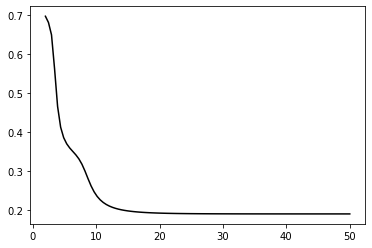

In [2]:
# Velocity model
# thickness, Vp, Vs, density
# km, km/s, km/s, g/cm3
thick = np.array([0.01, 0.04, 0.01])
vs = np.array([0.2, 0.4, 0.8])
velocity_model = np.vstack([thick, vs*4, vs, np.ones(3)]).T

# Frequency
fdisp = np.linspace(2, 50, 101)

# Periods must be sorted starting with low periods
period = np.flipud(1/fdisp)

# Compute the Rayleigh-wave modal dispersion curves
pd = PhaseDispersion(*velocity_model.T)
cpr = pd(period, mode=0, wave="rayleigh") 
vdisp = np.flipud(cpr[1])

plt.figure()
plt.plot(fdisp, vdisp, 'k');

## Seismogram

In [3]:
# Axes
nt = 600
dt = 0.008
nx = 201
dx = 2
nfft = 2**10

t, x = np.arange(nt)*dt, np.arange(nx)*dx
f = np.fft.rfftfreq(nfft, dt)
vf = np.interp(f, fdisp, vdisp)

# Wavelet
wav = ormsby(t[:nt//2+1], f=[2, 4, 38, 40], taper=np.hanning)[0][:-1]
wav = np.roll(np.fft.ifftshift(wav), 100)

dshift = surfacewavedata(nt, dt, nx, dx, nfft, fdisp, vdisp, wav)

# Dispersion panel

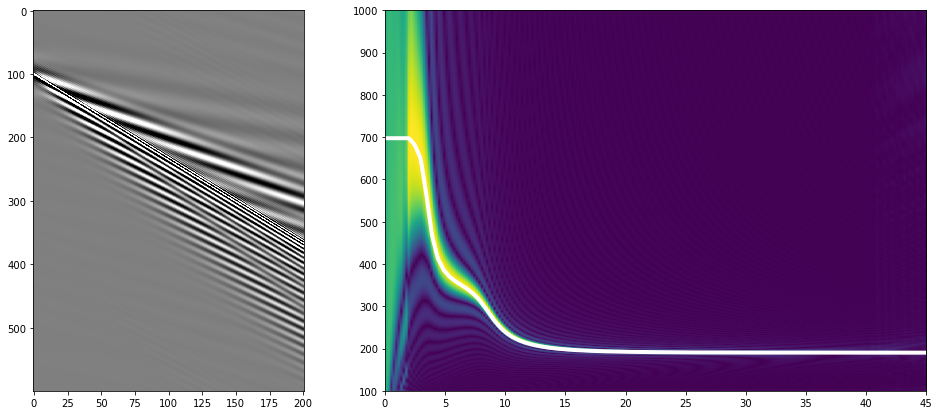

In [4]:
# Convert from f-kx to f-velocity (with function)
nvel = 401
vlims = (100, 1000)
vdispsp = np.linspace(vlims[0], vlims[1], nvel)
Ddispsp = parkdispersion(dshift, dx, dt, vdispsp[0], vdispsp[-1], vdispsp[1]-vdispsp[0], f[-1])[2]

fig, axs = plt.subplots(1, 2, figsize=(16, 7), gridspec_kw={'width_ratios': [1, 2]})
axs[0].imshow(dshift.T, cmap='gray', vmin=-.1, vmax=.1)
axs[0].axis('tight')
axs[1].imshow(Ddispsp, origin='lower', extent=(f[0], f[-1], vdispsp[0], vdispsp[-1]))
axs[1].plot(f, vf*1e3, 'w', lw=4)
axs[1].axis('tight')
axs[1].set_xlim(0, 45);

## Inversion

In [5]:
# Exact solution
nlayers = 3
thick0 = velocity_model[:, 0]
vs0 = velocity_model[:, 2]
    
x0 = np.hstack([thick0, vs0])
fun(x0.ravel(), nlayers=nlayers, t=period, vdispobs=np.flipud(vdisp))

0.0

In [6]:
# Wrong solution
nlayers = 3
thick0 = np.array([0.01, 0.04, 0.01])
vs0 = np.array([0.2, 0.3, 0.3])

x0 = np.hstack([thick0, vs0])
fun(x0.ravel(), nlayers=nlayers, t=period, vdispobs=np.flipud(vdisp))

0.8333433013531758

In [7]:
# Inverse
nlayers = 3
thick0 = np.array([0.02, 0.02, 0.02])
vs0 = np.array([0.2, 0.6, 0.6])
    
x0 = np.hstack([thick0, vs0])
bd = Bounds(lb=np.zeros(nlayers*2), ub=np.inf * np.ones(nlayers*2), keep_feasible=False)
nl = minimize(fun, x0.ravel(), args=(nlayers, period, np.flipud(vdisp)), bounds=bd,
              method='Nelder-Mead', options=dict(maxiter=1000))
thickest = nl.x[:nlayers]
vsest = nl.x[nlayers:]

print('Thickness', thick, thick0, thickest)
print('VS', vs, vs0, vsest)

Thickness [0.01 0.04 0.01] [0.02 0.02 0.02] [0.00999879 0.04000142 0.03551139]
VS [0.2 0.4 0.8] [0.2 0.6 0.6] [0.19999153 0.39998676 0.79999018]


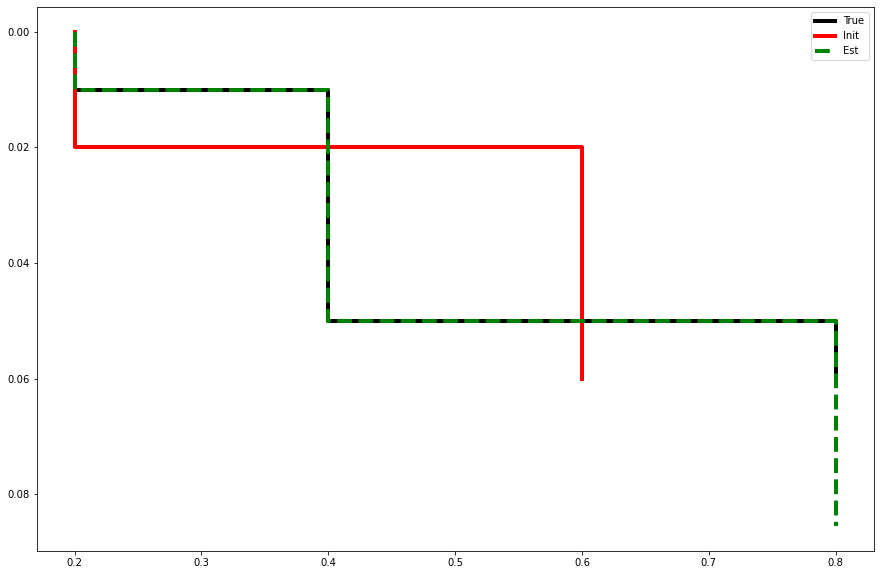

In [8]:
thickplt = np.insert(thick, 0, 0)
vsplt = np.insert(vs, -1, vs[-1])
thick0plt = np.insert(thick0, 0, 0)
vs0plt = np.insert(vs0, -1, vs0[-1])
thickestplt = np.insert(thickest, 0, 0)
vsestplt = np.insert(vsest, -1, vsest[-1])

plt.figure(figsize=(15, 10))
plt.step(vsplt, np.cumsum(thickplt), 'k', lw=4, label='True')
plt.step(vs0plt, np.cumsum(thick0plt), 'r', lw=4, label='Init')
plt.step(vsestplt, np.cumsum(thickestplt), '--g', lw=4, label='Est')
plt.gca().invert_yaxis()
plt.legend();